# Lab 5 Report: 
## Stock Prediction AI with Encoder-Decoder RNN

### Name:

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

In [66]:
from IPython.display import Image # For displaying images in colab jupyter cell

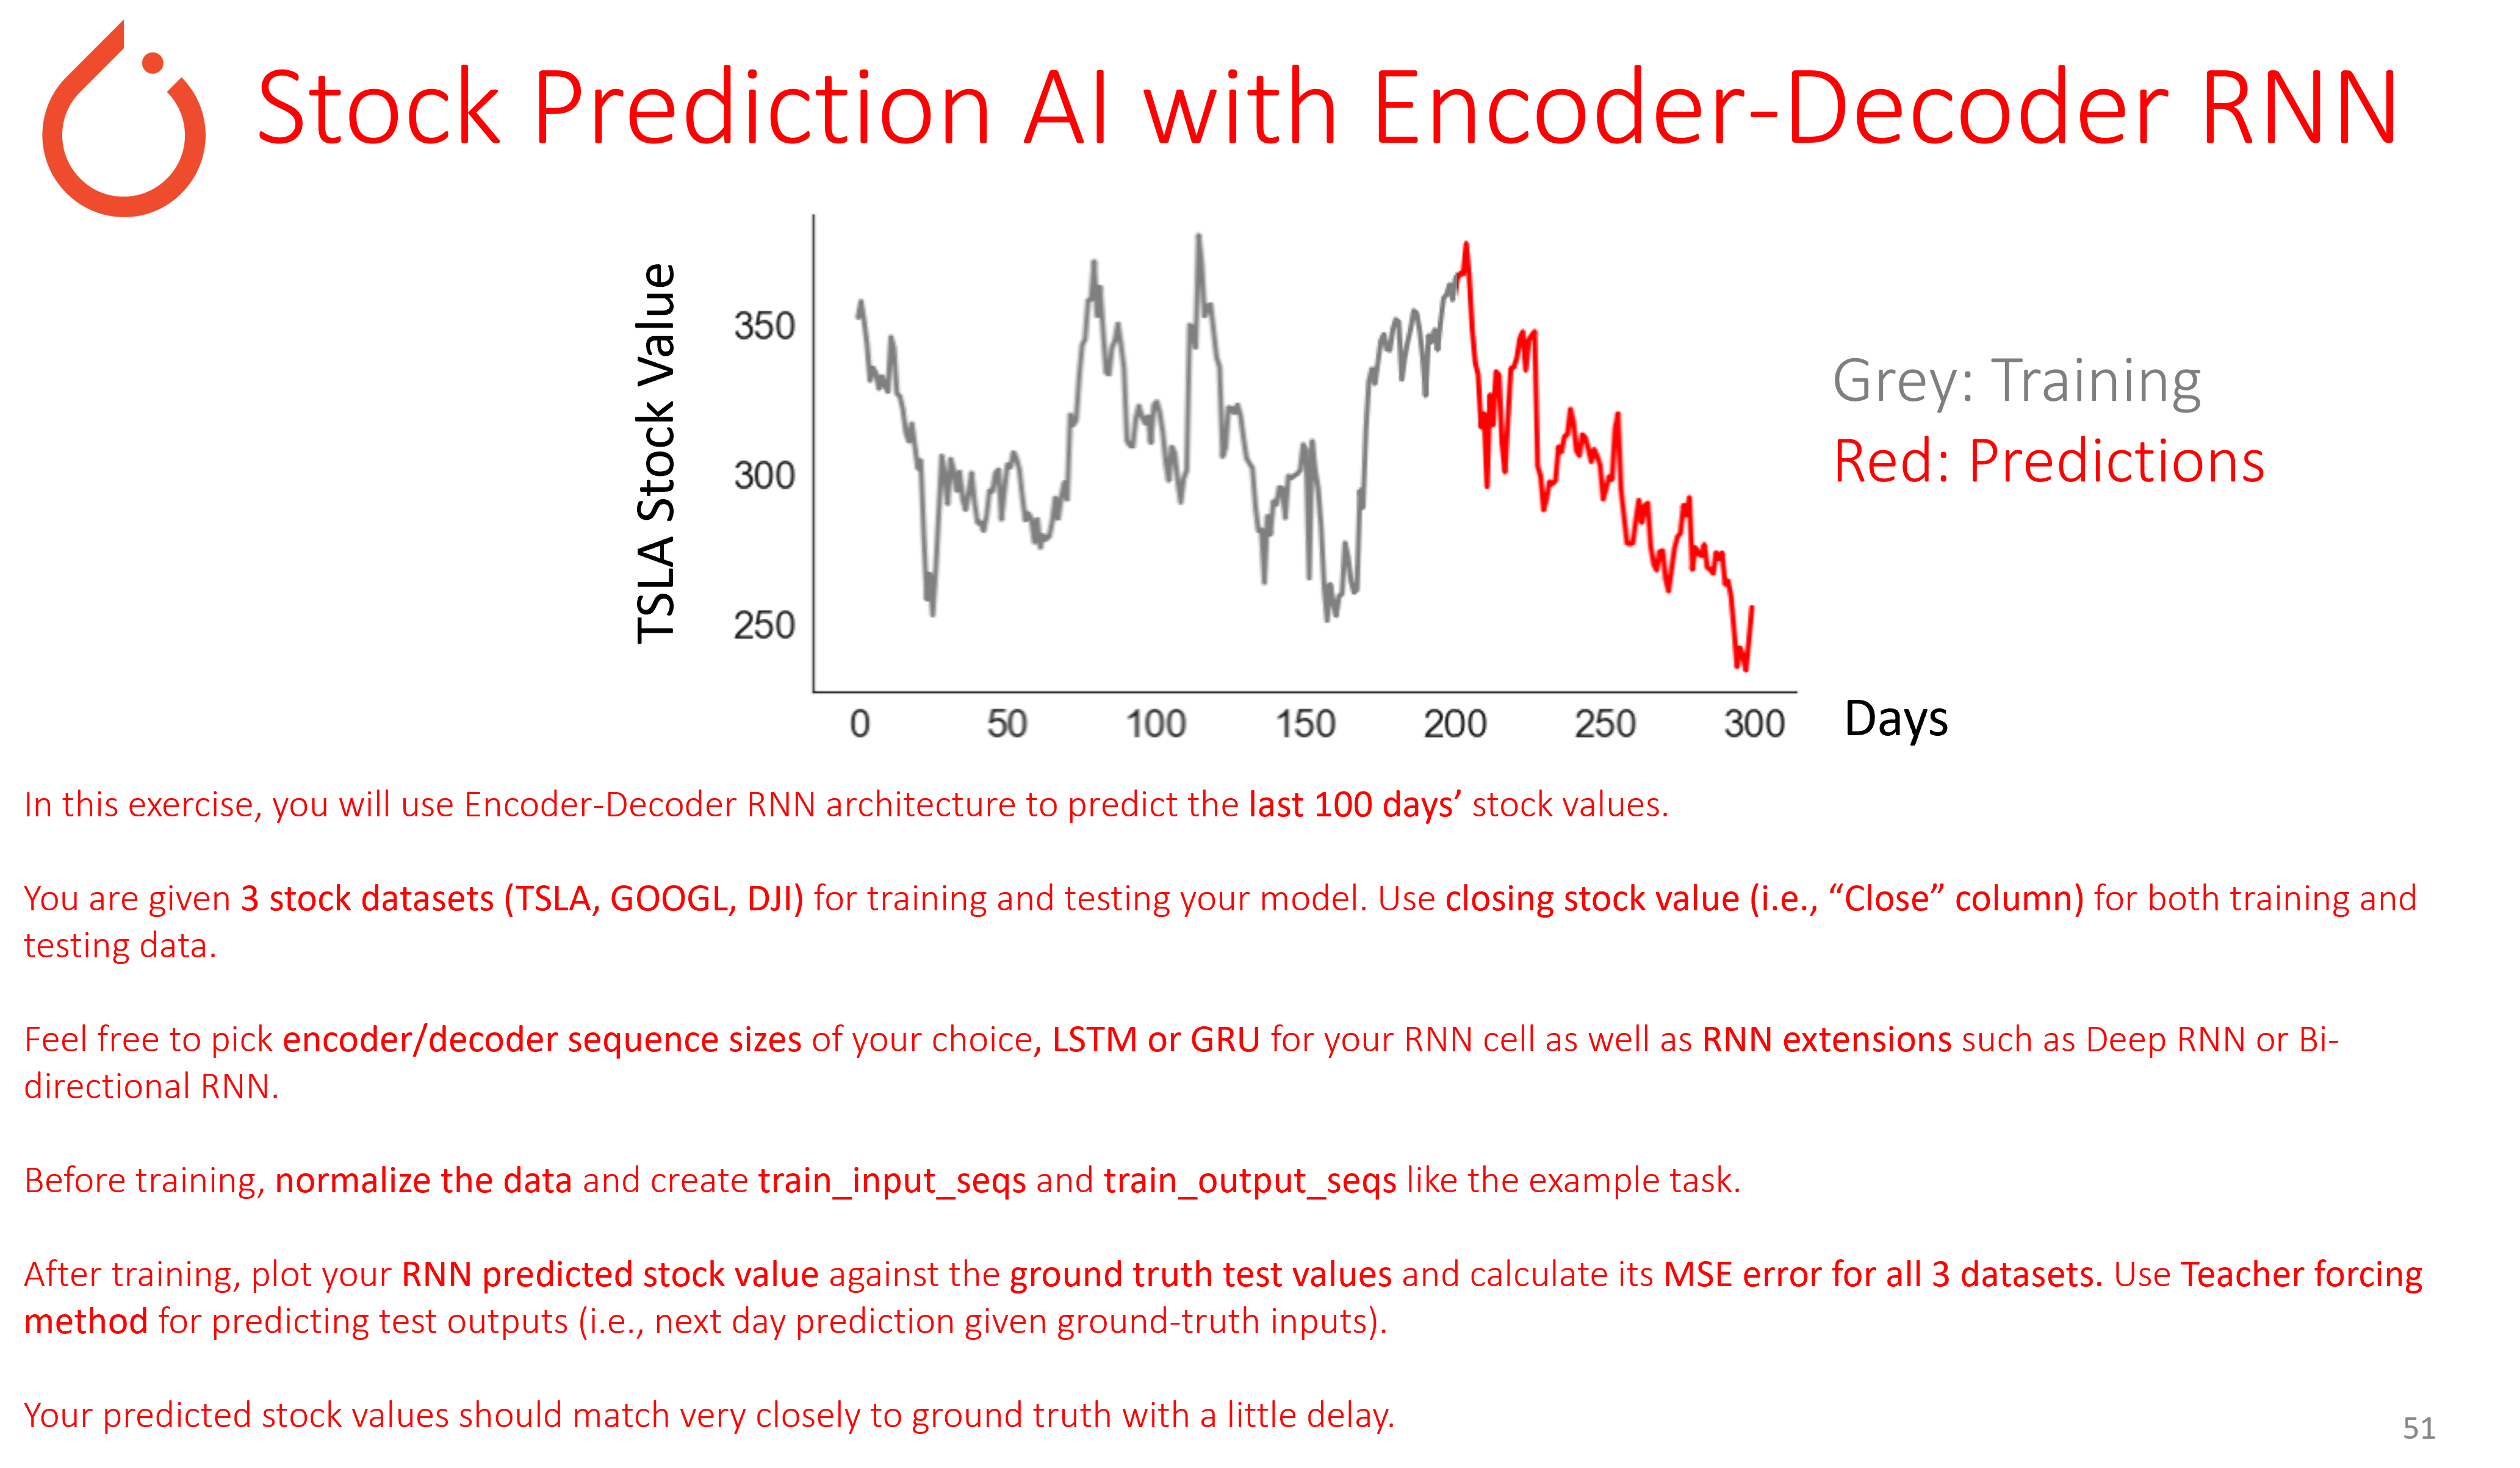

In [67]:
Image('lab5_exercise.png', width = 1000)

In [68]:
# Seaborn plot styling
sns.set(style = 'white', font_scale = 2)

## Prepare Data

In [69]:
# Load stock datasets
# Pick one of three to train your model 
# Use 'closing price' column for training and testing

tesla = pd.read_csv('TSLA.csv') 
tesla_np = tesla.to_numpy()

google = pd.read_csv('GOOGL.csv') 
google_np = google.to_numpy()

dji = pd.read_csv('DJI.csv') 
dji_np = dji.to_numpy()

In [70]:
tesla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


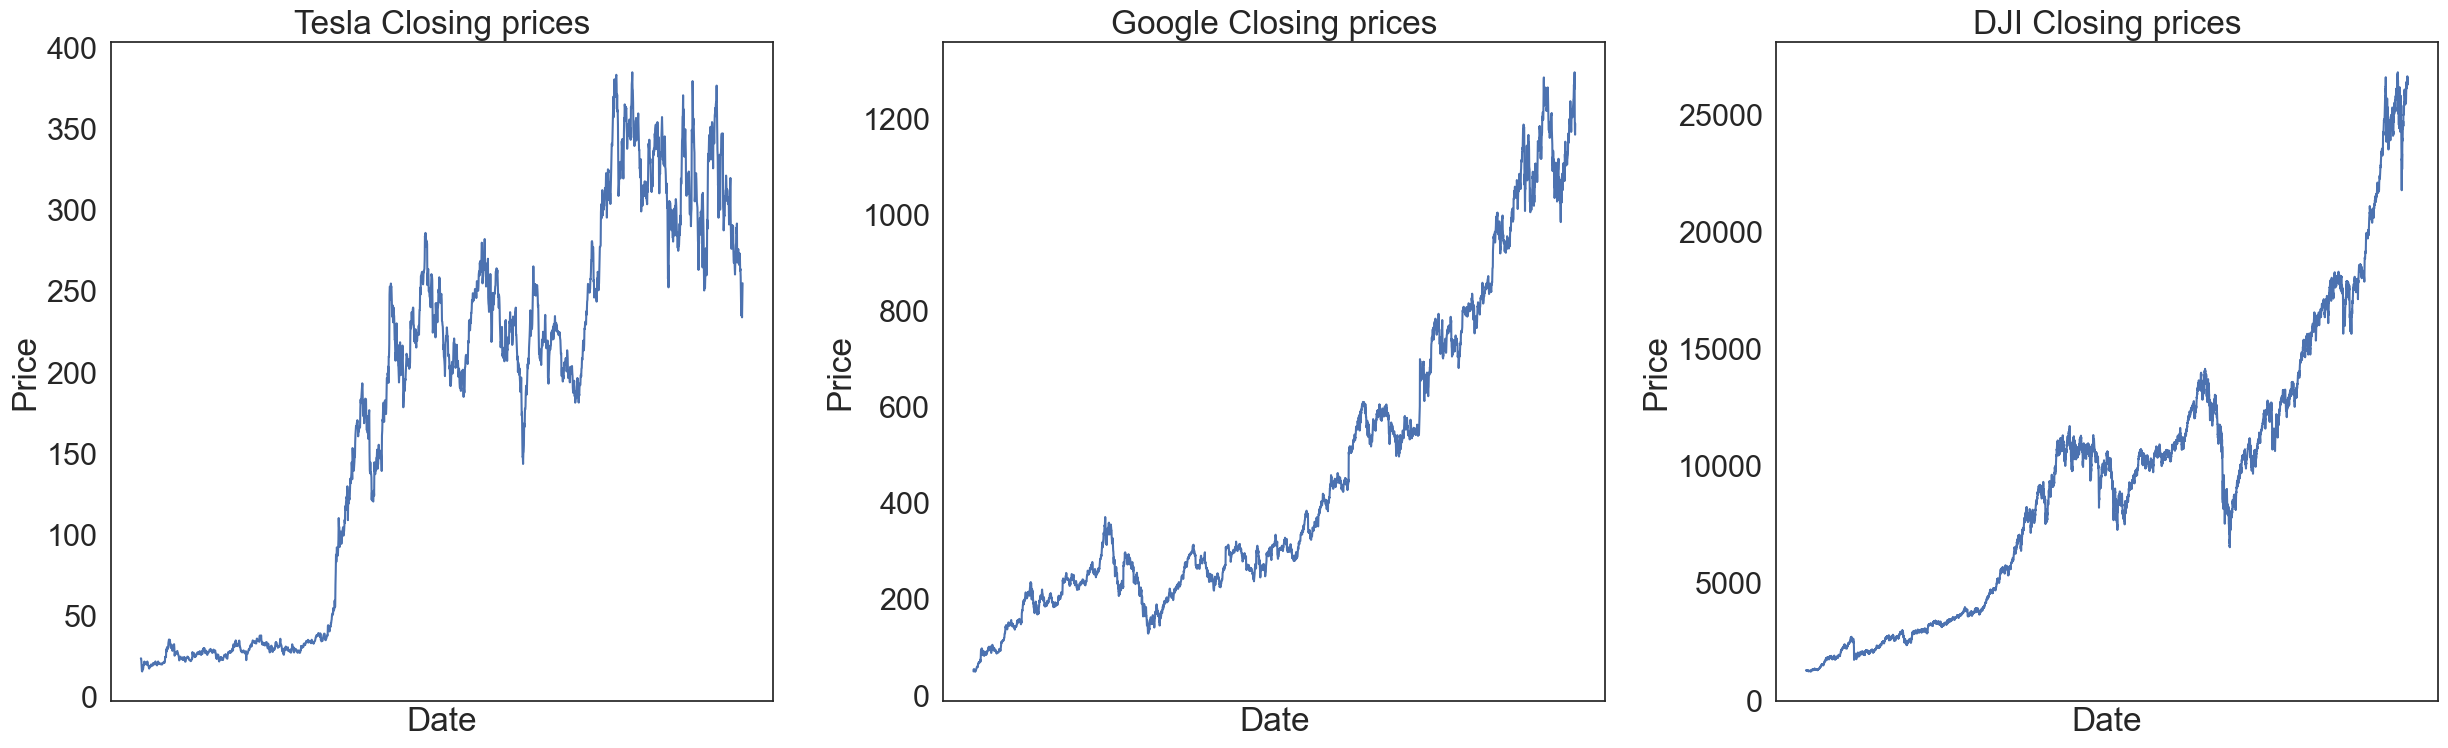

In [71]:
plt.figure(figsize = (25, 8))

plt.subplot(1, 3, 1)
plt.plot('Date', 'Close', data=tesla)
plt.title('Tesla Closing prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])

plt.subplot(1, 3, 2)
plt.plot('Date', 'Close', data=google)
plt.title('Google Closing prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])

plt.subplot(1, 3, 3)
plt.plot('Date', 'Close', data=dji)
plt.title('DJI Closing prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])

plt.tight_layout()
plt.show()

In [72]:
# Normalize your data and select training dataset (all the days except for last 100 days)

# YOUR CODE HERE

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

tesla_closes = scaler.fit_transform(tesla_np[:, 4].reshape(-1, 1))
google_closes = scaler.fit_transform(google_np[:, 4].reshape(-1, 1))
dji_closes = scaler.fit_transform(dji_np[:, 4].reshape(-1, 1))

In [73]:
print(tesla_np[:, 4], tesla_np[:, 4].shape)
tesla_closes

[23.889999 23.83 21.959999 ... 234.009995 244.100006 255.029999] (2227,)


array([[-1.32913376],
       [-1.32965451],
       [-1.34588488],
       ...,
       [ 0.49456796],
       [ 0.58214254],
       [ 0.6770076 ]], shape=(2227, 1))

In [74]:
def generate_input_output_seqs(y, encoder_inputseq_len, decoder_outputseq_len, stride = 1, num_features = 1):
  
    L = y.shape[0] # Length of y
    
    # Calculate how many input/target sequences there will be based on the parameters and stride
    num_samples = (L - encoder_inputseq_len - decoder_outputseq_len) // stride + 1
    
    # Numpy zeros arrray to contain the input/target sequences
    # Note that they should be in (num_samples, seq_len, num_features/time step) format
    train_input_seqs = np.zeros([num_samples, encoder_inputseq_len, num_features])
    train_output_seqs = np.zeros([num_samples, decoder_outputseq_len, num_features])    
    
    # Iteratively fill in train_input_seqs and train_output_seqs
    # See slide 17 of lab 7 to get an idea of how input_seqs and output_seqs look like
    for ff in np.arange(num_features):
        
        for ii in np.arange(num_samples):
            
            start_x = stride * ii
            end_x = start_x + encoder_inputseq_len
            train_input_seqs[ii, :, ff] = y[start_x:end_x, ff]

            start_y = stride * ii + encoder_inputseq_len
            end_y = start_y + decoder_outputseq_len 
            train_output_seqs[ii, :, ff] = y[start_y:end_y, ff]

    return train_input_seqs, train_output_seqs

In [75]:
# Define your encoder input sequence length, decoder output sequence length and testing sequence length
# Construct train_input_seqs and train_output_seqs according to 
# encoder input sequence length and decoder output sequence length similar to example task

encoder_inputseq_len = 5 
decoder_outputseq_len = 2 
testing_sequence_len = 100

tesla_train = tesla_closes[:-testing_sequence_len]
google_train = google_closes[:-testing_sequence_len]
dji_train = dji_closes[:-testing_sequence_len]

tesla_train_input_seqs, tesla_train_ouput_seqs = generate_input_output_seqs(tesla_train, encoder_inputseq_len, decoder_outputseq_len)
google_train_input_seqs, google_train_ouput_seqs = generate_input_output_seqs(google_train, encoder_inputseq_len, decoder_outputseq_len)
dji_train_input_seqs, dji_train_ouput_seqs = generate_input_output_seqs(dji_train, encoder_inputseq_len, decoder_outputseq_len)

In [76]:
# Make sure train_input_seqs and train_output_seqs have correct dimensions as expected
# (sample size, sequence length, # of features / timestep)

print("Encoder Training Inputs Shape: ", tesla_train_input_seqs.shape)
print("Decoder Training Outputs Shape: ", tesla_train_ouput_seqs.shape)

Encoder Training Inputs Shape:  (2121, 5, 1)
Decoder Training Outputs Shape:  (2121, 2, 1)


## Define Model

In [77]:
class Encoder(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        
        super(Encoder, self).__init__()

        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                                  num_layers = num_layers, 
                                  batch_first = True)
        
    def forward(self, input_seq, hidden_state):
        
        out, hidden = self.lstm(input_seq, hidden_state)
        
        return out, hidden     

class Decoder(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        
        super(Decoder, self).__init__()

        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                                  num_layers = num_layers,
                                  batch_first = True)
        
        self.fc_decoder = torch.nn.Linear(hidden_size, output_size)  

    def forward(self, input_seq, encoder_hidden_states):
        
        lstm_out, hidden = self.lstm(input_seq, encoder_hidden_states)
        out = self.fc_decoder(lstm_out)  
        
        return out, hidden

class Encoder_Decoder(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, decoder_output_size, num_layers):

        super(Encoder_Decoder, self).__init__()

        self.Encoder = Encoder(input_size = input_size, hidden_size = hidden_size, 
                               num_layers = num_layers)
        
        self.Decoder = Decoder(input_size = input_size, hidden_size = hidden_size, 
                               output_size = decoder_output_size, num_layers = num_layers)

## Define Hyperparameters

In [78]:
torch.manual_seed(2)

Encoder_Decoder_RNN =Encoder_Decoder(input_size = 1, hidden_size = 15, 
                                     decoder_output_size = 1, num_layers = 1)

learning_rate = 1e-2 
epochs = 50

batchsize = 5
num_features = 1

loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Encoder_Decoder_RNN.parameters(), lr=learning_rate)

Encoder_Decoder_RNN

Encoder_Decoder(
  (Encoder): Encoder(
    (lstm): LSTM(1, 15, batch_first=True)
  )
  (Decoder): Decoder(
    (lstm): LSTM(1, 15, batch_first=True)
    (fc_decoder): Linear(in_features=15, out_features=1, bias=True)
  )
)

## Identify Tracked Values

In [ ]:
# YOUR CODE HERE

## Train Model

In [ ]:
# YOUR CODE HERE (You can train 3 models for each dataset or a single model for all three datasets)

## Visualize & Evaluate Model

In [ ]:
# YOUR CODE HERE

In [ ]:
# Define your testing sequences

In [ ]:
# Visualize the testing sequence

### Generate signal predictions for testing sequence with trained Encoder-Decoder

In [ ]:
# USE TEACHER FORCING METHOD WHEN GENERATING OUTPUTS FROM DECODER
# When generating decoder outputs, make sure each input to decoder at timestep t has the shape (1,1,1)
# i.e., num_samples = 1, sequence_len = 1, num_features = 1 

# YOUR CODE HERE

In [ ]:
# Visualize predicted stock sequence vs the ground truth (TSLA)

plt.figure(figsize = (10, 5))

plt.plot(test_input_seq_TSLA, linewidth = 3, label = 'GroundTruth')
plt.plot(decoder_output_seq_TSLA, linewidth = 3, label = 'RNN Predicted')
plt.title('RNN Predicted vs GroundTruth')
plt.legend()
sns.despine()

In [ ]:
# Visualize predicted stock sequence vs the ground truth (GOOGLE)

plt.figure(figsize = (10, 5))

plt.plot(test_input_seq_GOOGLE, linewidth = 3, label = 'GroundTruth')
plt.plot(decoder_output_seq_GOOGLE, linewidth = 3, label = 'RNN Predicted')
plt.title('RNN Predicted vs GroundTruth')
plt.legend()
sns.despine()

In [ ]:
# Visualize predicted stock sequence vs the ground truth (DJI)

plt.figure(figsize = (10, 5))

plt.plot(test_input_seq_DJI, linewidth = 3, label = 'GroundTruth')
plt.plot(decoder_output_seq_DJI, linewidth = 3, label = 'RNN Predicted')
plt.title('RNN Predicted vs GroundTruth')
plt.legend()
sns.despine()

In [ ]:
# Compute the MSE errors between test_input_seq and decoder_output_seq and print the value as Test MSE Error for all 3 datasets
# 

# YOUR CODE HERE